**Imports and includes**

In [1]:
import csv
import numpy as np 
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt 
import pickle
import statistics
import numpy as np  
import sys
import glob

pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 200)

In [2]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

**Sentiment analysis function provided by Upasana**

In [4]:
def sentiment_analyzer_score_for_englishOnlyTweet(cleaned_tweet): #this function takes in a tweet that has been detected as an english tweet
    score = analyser.polarity_scores(cleaned_tweet) #so this cleaned_tweet is always an english tweet.
    lb = score['compound']
    return lb

**Create list of all Baseline Users**

In [5]:
all_user_lists=[
#     "/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/DidNotMentionBack_Users/Filtered_EnglishUsers_DidNotMentionedBackUsers_FINAL.csv",
    "/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/MentionedBack_Users/Filtered_EnglishUsers_MentionedBackUsers_FINAL.csv",
#     '../BeforeAndAfterAnalysis/Filtered_EnglishUsers_DidnotMentionBackUsers.csv',
    '../BeforeAndAfterAnalysis/Filtered_EnglishUsers_MentionBackedUsers.csv']

UserList = []
userPathDict = {}
for i in range(2):  
    df = pd.read_csv(all_user_lists[i])
    tempUserList = list(df['Users'])
    for j in range(len(tempUserList)):
        UserList.append(tempUserList[j])
        if (i == 0) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'
# #         elif (i == 1) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'
        elif (i == 1) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'
#         elif (i == 3) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'
    

In [6]:
print("Number of possibly affected users: " + str(len(UserList)))

Number of possibly affected users: 1104


In [7]:
# with open('pau_all.txt', 'w') as filehandle:
#     for listitem in UserList:
#         filehandle.write('%s\n' % listitem)

**Functions to check for a mention of Donald Trump or Hillary Clinton in a tweet**

In [8]:
def mentions_trump(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'realdonaldtrump':
                return True
    return False

In [9]:
def mentions_clinton(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'hillaryclinton':
                return True
    return False

**Calculate monthy values for each user (over the 96 months from Jan 2009 to December 2016)**

In [10]:
timelineDict = {}

In [11]:
firstTweetIndexDict = {}

In [12]:
timelineDF = pd.DataFrame(columns=['username','tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent',
                                      'positive_sent', 'negative_sent'])

In [13]:
size = str(len(UserList))
for i in range(len(UserList)):
# for i in range(100):
    try:
        #read in, reverse order (so oldest is first), reset index
        temp_user_db = pd.read_csv(userPathDict[UserList[i]]+UserList[i]+'.csv', header=None, low_memory=False)
        temp_user_db = temp_user_db.iloc[::-1]
        temp_user_db.reset_index(drop=True, inplace=True)

        #create lists for each metric
        tweet_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        trump_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        clinton_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        sentiment_scores = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        trump_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        clinton_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        positive_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        negative_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]

        #iterate through user tweets
        first = 1
        for j in range(len(temp_user_db)):

            #step one is assigning an index for the tweet, based on date, or disregarding
            found = 0
            tweetdate = dt.strptime(temp_user_db[3][j], "%Y-%m-%d")
            for k in range(2009,2017):
                temp_year = k
                date_start = dt(temp_year,1,1)
                date_end = dt(temp_year,12,31)
                if tweetdate < date_start:
                    continue;
                elif tweetdate <= date_end:
                    for m in range(2,14):
                        if m == 13: #month must be December by process of elimination
                            use_index = (((k-2009)*12)+(m-2))
                            found = 1
    #                         print(temp_user_db['date'][j] + " " +str(use_index))
                            break;
                        next_month_start = dt(temp_year,m,1)
                        if tweetdate < next_month_start:
                            use_index = (((k-2009)*12)+(m-2))
                            found = 1
    #                         print(temp_user_db['date'][j] + " " +str(use_index))
                            break;

            #tweet occurred within the period 2009-2016 and was assigned an valid index
            if found == 1:
                if first:
                    firstTweetIndexDict[UserList[i]] = use_index
                    first = 0

                tweet_count[use_index] +=1

                tweet_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
                sentiment_scores[use_index].append(tweet_sent)

                trump_flag = mentions_trump(str(temp_user_db[11][j]))
                clinton_flag = mentions_clinton(str(temp_user_db[11][j]))

                if trump_flag: trump_count[use_index] += 1
                if clinton_flag: clinton_count[use_index] += 1

                if trump_flag and not clinton_flag: trump_sent[use_index].append(tweet_sent)
                if clinton_flag and not trump_flag: clinton_sent[use_index].append(tweet_sent)

                if tweet_sent > 0: positive_sent[use_index].append(tweet_sent)
                if tweet_sent < 0: negative_sent[use_index].append(tweet_sent)

        timelineDict[UserList[i]] = [tweet_count, sentiment_scores, trump_count, clinton_count, 
                                     trump_sent, clinton_sent, positive_sent, negative_sent]

        print(str(i) + " / " + size)

    except Exception as e: 
        print(str(UserList[i]) + " failed - " + str(e))

        

0 / 1104
1 / 1104
2 / 1104
3 / 1104
4 / 1104
5 / 1104
6 / 1104
7 / 1104
8 / 1104
9 / 1104
10 / 1104
11 / 1104
12 / 1104
13 / 1104
14 / 1104
15 / 1104
16 / 1104
17 / 1104
18 / 1104
19 / 1104
20 / 1104
21 / 1104
22 / 1104
23 / 1104
24 / 1104
25 / 1104
26 / 1104
27 / 1104
28 / 1104
29 / 1104
30 / 1104
31 / 1104
32 / 1104
33 / 1104
34 / 1104
35 / 1104
36 / 1104
37 / 1104
38 / 1104
39 / 1104
40 / 1104
41 / 1104
42 / 1104
43 / 1104
44 / 1104
45 / 1104
46 / 1104
47 / 1104
48 / 1104
49 / 1104
50 / 1104
51 / 1104
52 / 1104
53 / 1104
54 / 1104
55 / 1104
56 / 1104
57 / 1104
58 / 1104
59 / 1104
60 / 1104
61 / 1104
62 / 1104
63 / 1104
64 / 1104
65 / 1104
66 / 1104
67 / 1104
68 / 1104
69 / 1104
70 / 1104
71 / 1104
72 / 1104
73 / 1104
74 / 1104
75 / 1104
76 / 1104
77 / 1104
78 / 1104
79 / 1104
80 / 1104
81 / 1104
82 / 1104
83 / 1104
84 / 1104
85 / 1104
86 / 1104
87 / 1104
88 / 1104
89 / 1104
90 / 1104
91 / 1104
92 / 1104
93 / 1104
94 / 1104
95 / 1104
96 / 1104
97 / 1104
98 / 1104
99 / 1104
100 / 1104

755 / 1104
756 / 1104
757 / 1104
758 / 1104
759 / 1104
760 / 1104
761 / 1104
762 / 1104
763 / 1104
764 / 1104
765 / 1104
766 / 1104
767 / 1104
768 / 1104
769 / 1104
770 / 1104
771 / 1104
772 / 1104
773 / 1104
774 / 1104
775 / 1104
776 / 1104
777 / 1104
778 / 1104
779 / 1104
780 / 1104
781 / 1104
782 / 1104
783 / 1104
784 / 1104
785 / 1104
786 / 1104
787 / 1104
788 / 1104
789 / 1104
790 / 1104
791 / 1104
792 / 1104
793 / 1104
794 / 1104
795 / 1104
796 / 1104
797 / 1104
798 / 1104
799 / 1104
800 / 1104
801 / 1104
802 / 1104
803 / 1104
804 / 1104
805 / 1104
806 / 1104
807 / 1104
808 / 1104
809 / 1104
810 / 1104
811 / 1104
812 / 1104
813 / 1104
814 / 1104
815 / 1104
816 / 1104
817 / 1104
818 / 1104
819 / 1104
820 / 1104
821 / 1104
822 / 1104
823 / 1104
824 / 1104
825 / 1104
826 / 1104
827 / 1104
828 / 1104
829 / 1104
830 / 1104
831 / 1104
832 / 1104
833 / 1104
834 / 1104
835 / 1104
836 / 1104
837 / 1104
838 / 1104
839 / 1104
840 / 1104
841 / 1104
842 / 1104
843 / 1104
844 / 1104
845 / 1104

In [14]:
len(firstTweetIndexDict)

1070

In [15]:
for i in range(len(timelineDF)):
    try:
        test = firstTweetIndexDict[timelineDF['username'][i]]
    except:
        print(timelineDF['username'][i] + ' failed [' +str(i)+']' )

In [16]:
timelineDF = pd.DataFrame.from_dict(timelineDict, orient='index',columns=['tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent',
                                      'positive_sent', 'negative_sent'])

timelineDF.index.name = 'username'
timelineDF.reset_index(inplace=True)


In [17]:
len(timelineDF)

1100

In [18]:
tweet_countDict = {}
sentiment_scoresDict = {}
trump_countDict = {}
clinton_countDict = {}
trump_sentDict = {}
clinton_sentDict = {}
positive_sentDict = {}
negative_sentDict = {} 

In [19]:
size = str(len(timelineDF))
for i in range(len(timelineDF)):
    try:
        start_index = firstTweetIndexDict[timelineDF['username'][i]]

        tweet_count = []
        sentiment_scores = []
        trump_count = []
        clinton_count = []
        trump_sent = []
        clinton_sent = []
        positive_sent = []
        negative_sent = [] 

        for j in range(0,96):
            if j >= start_index:
                tweet_count.append(timelineDF['tweet_count'][i][j])
                trump_count.append(timelineDF['trump_count'][i][j])
                clinton_count.append(timelineDF['clinton_count'][i][j])

                if(len(timelineDF['sentiment_scores'][i][j]) > 0):
                    sentiment_scores.append(statistics.mean(timelineDF['sentiment_scores'][i][j]))
                else:
                    sentiment_scores.append(np.nan)

                if(len(timelineDF['trump_sent'][i][j]) > 0):
                    trump_sent.append(statistics.mean(timelineDF['trump_sent'][i][j]))
                else:
                    trump_sent.append(np.nan)

                if(len(timelineDF['clinton_sent'][i][j]) > 0):
                    clinton_sent.append(statistics.mean(timelineDF['clinton_sent'][i][j]))
                else:
                    clinton_sent.append(np.nan)

                if(len(timelineDF['positive_sent'][i][j]) > 0):
                    positive_sent.append(statistics.mean(timelineDF['positive_sent'][i][j]))
                else:
                    positive_sent.append(np.nan)

                if(len(timelineDF['negative_sent'][i][j]) > 0):
                    negative_sent.append(statistics.mean(timelineDF['negative_sent'][i][j]))
                else:
                    negative_sent.append(np.nan)

            else:
                tweet_count.append(np.nan)
                trump_count.append(np.nan)
                clinton_count.append(np.nan)
                sentiment_scores.append(np.nan)
                trump_sent.append(np.nan)
                clinton_sent.append(np.nan)
                positive_sent.append(np.nan)
                negative_sent.append(np.nan)

        tweet_countDict[timelineDF['username'][i]] = tweet_count
        sentiment_scoresDict[timelineDF['username'][i]] = sentiment_scores
        trump_countDict[timelineDF['username'][i]] = trump_count
        clinton_countDict[timelineDF['username'][i]] = clinton_count
        trump_sentDict[timelineDF['username'][i]] = trump_sent
        clinton_sentDict[timelineDF['username'][i]] = clinton_sent
        positive_sentDict[timelineDF['username'][i]] = positive_sent
        negative_sentDict[timelineDF['username'][i]] =  negative_sent 

        print(str(i) + " / " + size)
        
    except Exception as e: 
        print(str(timelineDF['username'][i]) + " failed - " + str(e))

0 / 1100
1 / 1100
2 / 1100
3 / 1100
4 / 1100
5 / 1100
6 / 1100
7 / 1100
8 / 1100
9 / 1100
10 / 1100
11 / 1100
12 / 1100
13 / 1100
14 / 1100
15 / 1100
16 / 1100
17 / 1100
ThomasMHern failed - 'ThomasMHern'
19 / 1100
20 / 1100
21 / 1100
22 / 1100
23 / 1100
24 / 1100
25 / 1100
26 / 1100
27 / 1100
28 / 1100
29 / 1100
30 / 1100
31 / 1100
32 / 1100
33 / 1100
34 / 1100
35 / 1100
36 / 1100
37 / 1100
38 / 1100
39 / 1100
40 / 1100
41 / 1100
42 / 1100
43 / 1100
44 / 1100
45 / 1100
46 / 1100
47 / 1100
48 / 1100
49 / 1100
50 / 1100
51 / 1100
52 / 1100
53 / 1100
54 / 1100
55 / 1100
56 / 1100
57 / 1100
58 / 1100
59 / 1100
60 / 1100
61 / 1100
62 / 1100
63 / 1100
64 / 1100
65 / 1100
66 / 1100
67 / 1100
68 / 1100
69 / 1100
70 / 1100
71 / 1100
72 / 1100
73 / 1100
74 / 1100
75 / 1100
76 / 1100
77 / 1100
78 / 1100
79 / 1100
80 / 1100
81 / 1100
82 / 1100
83 / 1100
84 / 1100
85 / 1100
86 / 1100
87 / 1100
88 / 1100
whirrll failed - 'whirrll'
90 / 1100
91 / 1100
92 / 1100
93 / 1100
beerscouts failed - 'beersco

702 / 1100
703 / 1100
704 / 1100
705 / 1100
706 / 1100
707 / 1100
708 / 1100
709 / 1100
710 / 1100
711 / 1100
712 / 1100
713 / 1100
714 / 1100
715 / 1100
716 / 1100
717 / 1100
718 / 1100
719 / 1100
720 / 1100
721 / 1100
722 / 1100
723 / 1100
724 / 1100
725 / 1100
726 / 1100
727 / 1100
728 / 1100
729 / 1100
730 / 1100
731 / 1100
732 / 1100
733 / 1100
734 / 1100
735 / 1100
736 / 1100
737 / 1100
738 / 1100
739 / 1100
740 / 1100
741 / 1100
742 / 1100
743 / 1100
744 / 1100
745 / 1100
746 / 1100
747 / 1100
748 / 1100
749 / 1100
750 / 1100
751 / 1100
752 / 1100
753 / 1100
754 / 1100
755 / 1100
756 / 1100
757 / 1100
758 / 1100
759 / 1100
760 / 1100
761 / 1100
762 / 1100
763 / 1100
764 / 1100
765 / 1100
766 / 1100
767 / 1100
768 / 1100
769 / 1100
770 / 1100
771 / 1100
772 / 1100
773 / 1100
774 / 1100
775 / 1100
776 / 1100
777 / 1100
778 / 1100
779 / 1100
780 / 1100
781 / 1100
782 / 1100
783 / 1100
784 / 1100
785 / 1100
786 / 1100
787 / 1100
788 / 1100
789 / 1100
790 / 1100
791 / 1100
792 / 1100

In [20]:
tweet_countDF = pd.DataFrame.from_dict(tweet_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
tweet_countDF.index.name = 'username'
tweet_countDF.reset_index(inplace=True)
tweet_countDF = tweet_countDF.drop(columns=['username'])

trump_countDF = pd.DataFrame.from_dict(trump_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
trump_countDF.index.name = 'username'
trump_countDF.reset_index(inplace=True)
trump_countDF = trump_countDF.drop(columns=['username'])

clinton_countDF = pd.DataFrame.from_dict(clinton_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
clinton_countDF.index.name = 'username'
clinton_countDF.reset_index(inplace=True)
clinton_countDF = clinton_countDF.drop(columns=['username'])

sentiment_scoresDF = pd.DataFrame.from_dict(sentiment_scoresDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
sentiment_scoresDF.index.name = 'username'
sentiment_scoresDF.reset_index(inplace=True)
sentiment_scoresDF = sentiment_scoresDF.drop(columns=['username'])

trump_sentDF = pd.DataFrame.from_dict(trump_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
trump_sentDF.index.name = 'username'
trump_sentDF.reset_index(inplace=True)
trump_sentDF = trump_sentDF.drop(columns=['username'])

clinton_sentDF = pd.DataFrame.from_dict(clinton_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
clinton_sentDF.index.name = 'username'
clinton_sentDF.reset_index(inplace=True)
clinton_sentDF = clinton_sentDF.drop(columns=['username'])

positive_sentDF = pd.DataFrame.from_dict(positive_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
positive_sentDF.index.name = 'username'
positive_sentDF.reset_index(inplace=True)
positive_sentDF = positive_sentDF.drop(columns=['username'])

negative_sentDF = pd.DataFrame.from_dict(negative_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
negative_sentDF.index.name = 'username'
negative_sentDF.reset_index(inplace=True)
negative_sentDF = negative_sentDF.drop(columns=['username'])

In [21]:
timelineDF.to_pickle("./RESP_PAU_timelineDF_090320.pkl")

In [22]:
tweet_countDF.to_pickle("./RESP_PAU_tweet_countDF_090320.pkl")
trump_countDF.to_pickle("./RESP_PAU_trump_countDF_090320.pkl")
clinton_countDF.to_pickle("./RESP_PAU_clinton_countDF_090320.pkl")
sentiment_scoresDF.to_pickle("./RESP_PAU_sentiment_scoresDF_090320.pkl")
trump_sentDF.to_pickle("./RESP_PAU_trump_sentDF_090320.pkl")
clinton_sentDF.to_pickle("./RESP_PAU_clinton_sentDF_090320.pkl")
positive_sentDF.to_pickle("./RESP_PAU_positive_sentDF_090320.pkl")
negative_sentDF.to_pickle("./RESP_PAU_negative_sentDF_090320.pkl")


In [23]:
# unpickled_df = pd.read_pickle("./negative_sentDF_090320.pkl")

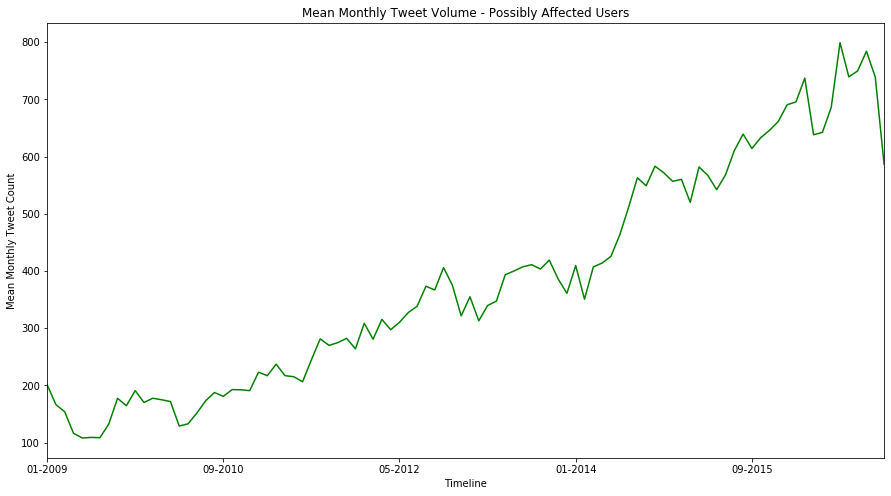

In [24]:
plt.figure()
tweet_countDF.mean().plot(kind='line', color='green', figsize=(15,8),title='Mean Monthly Tweet Volume - Possibly Affected Users')
# plt.legend(('Trump','Hillary'))
plt.ylabel('Mean Monthly Tweet Count')
plt.xlabel('Timeline')
plt.savefig('PAU_graphics/RESP_pau_tweetcount.png')
plt.show()

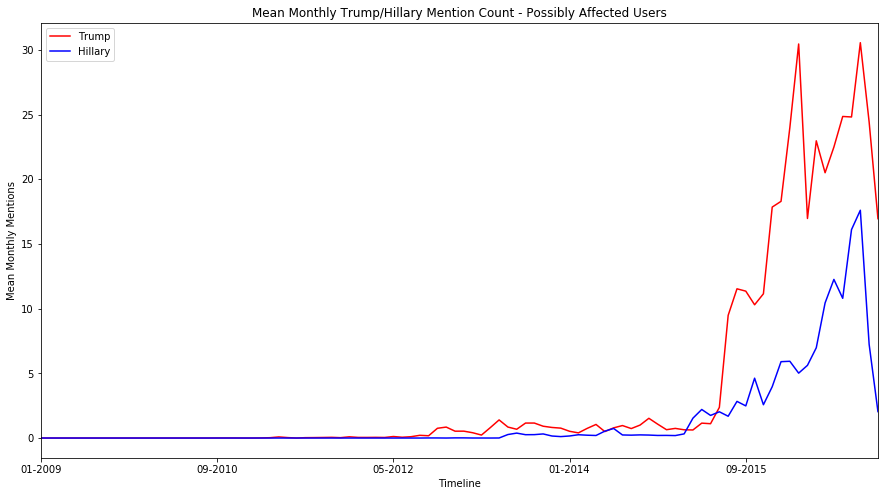

In [25]:
plt.figure()
trump_countDF.mean().plot(kind='line', color='red', figsize=(15,8),title='Mean Monthly Trump/Hillary Mention Count - Possibly Affected Users')
clinton_countDF.mean().plot(kind='line', color='blue', figsize=(15,8))
plt.legend(('Trump','Hillary'))
plt.ylabel('Mean Monthly Mentions')
plt.savefig('PAU_graphics/RESP_pau_mentions.png')
plt.xlabel('Timeline')
plt.show()

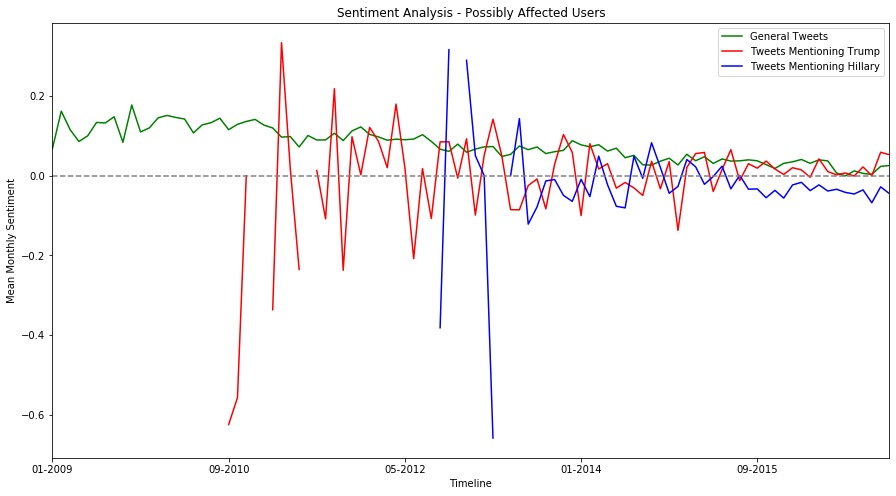

In [26]:
plt.figure()
sentiment_scoresDF.mean().plot(kind='line', color='green', figsize=(15,8),title='Sentiment Analysis - Possibly Affected Users')
trump_sentDF.mean().plot(kind='line', color='red', figsize=(15,8))
clinton_sentDF.mean().plot(kind='line', color='blue', figsize=(15,8))
plt.legend(('General Tweets','Tweets Mentioning Trump','Tweets Mentioning Hillary'))
plt.axhline(0, color="grey", linestyle="--")
plt.ylabel('Mean Monthly Sentiment')
plt.savefig('PAU_graphics/RESP_pau_sentiment.png')
plt.xlabel('Timeline')
plt.show()